# Comparaison variantes du TDM vs. modèles baselines sur des oeuvres de Fauré, Beethoven et Bach

## 1. Library import

In [ ]:
import os

# data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# initialisation and evaluation of models
import torch
from torch.distributions.poisson import Poisson
from torch.distributions.binomial import Binomial
from torch.distributions.gamma import Gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm

# models
from tonal_diffusion_model_revised import TonalDiffusionModel, GaussianModel, StaticDistributionModel, FactorModel, SimpleStaticDistributionModel

# tests
from scipy.stats import mannwhitneyu

from mixed_tdm import MultiCenterTDM

## 2. Replication of Lieck Lieck, Moss & Rohrmeier on the Fauré corpus + evaluation of the new TDM Binomial 3D (with tritones)

### 2.1 Data import and description

In [ ]:
faure = pd.read_csv(r"C:\Users\sacha\Videos\site_projet_flask - Copie\data\corpusfaurecomplete.csv")

In [ ]:
# harmonising values and cleaning datatypes
faure["date"] = faure["date"].astype(int)
faure["instruments"] = faure["instruments"].replace("vocale", "vocal")
faure["instruments"] = faure["instruments"].replace("chamber ", "chamber")
faure["instruments"] = faure["instruments"].replace("vocal ", "vocal")
inst = faure["instruments"].value_counts()

In [ ]:
# panel of countplots and histograms
figure = plt.figure(figsize=(15, 4))


plt.subplot(1,3,1)
sns.countplot(x = faure["periode"])
plt.gca().set_xlabel("Period")
plt.title("a)")

plt.subplot(1,3,2)
sns.histplot(faure["date"])
plt.gca().set_xlabel("Date of composition")
plt.title("b)")

plt.subplot(1,3,3)
sns.countplot(x = faure["instruments"])
plt.gca().set_ylabel("Count")
plt.gca().set_xlabel("Instrumentation")
plt.title("c)")

### Data manipulation 

Some manipulations to extract TPCs (tonal pitch classes) from the corpus.

In [ ]:
def do_count(dataset):
    #  reducing the dataset to TPCs (tonal pitch classes), assigning weights to pieces, gathering their titles
    weights = np.ones(len(dataset))
    titles = dataset.title.values
    counts = dataset.iloc[:, :-10].values
    data = counts / counts.sum(axis = 1, keepdims = True)
    return data, weights, titles
data_faure, weights_faure, titles_faure = do_count(faure)


In [ ]:
# true labels of notes (which are numerically encoded by the TDM)
notes = ['Fbb', 'Cbb', 'Gbb', 'Dbb', 'Abb', 'Ebb', 'Bbb', 'Fb', 'Cb', 'Gb', 'Db',
       'Ab', 'Eb', 'Bb', 'F', 'C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#',
       'D#', 'A#', 'E#', 'B#', 'F##', 'C##', 'G##', 'D##', 'A##', 'E##', 'B##']

## 2.2 Evaluation functions

In [ ]:
"""The original model evaluation script provided by the authors used a secret "WarmAdam" module... We attempted to recreate it;
 however, having observed no significant performance improvements during testing, we did not use it in this notebook."""

class WarmAdam(Adam):
    """The idea seems to be to initialize a relatively high learning rate to "warm up" the optimizer, before gradually lowering it using a multiplier. 
    This is what we deduced from the three-parameter name (lr=1e-3, init_lr=1e-2, lr_beta=0.95) 
    that the authors gave to their mysterious "WarmAdam"."""
    def __init__(self, params, lr=1e-3, init_lr=1e-2, lr_beta=0.95, **kwargs):
        super().__init__(params, lr=lr, **kwargs)
        self.init_lr = init_lr
        self.lr_beta = lr_beta
        self._step = 0

        # initialising  learning rates to init_lr
        for group in self.param_groups:
            group['lr'] = self.init_lr

    def step(self, closure=None):
        loss = super().step(closure)
        self._step += 1

        # progressive lr decay towards final value
        for group in self.param_groups:
            new_lr = max(group['lr'] * self.lr_beta, self.defaults['lr'])
            group['lr'] = new_lr
        return loss

Specific evaluation loop for TDM: this is a simplified version of the evaluation code provided by the authors of TDM: https://github.com/DCMLab/tonal-diffusion-model/blob/TISMIR/evaluation.py

In [14]:

def evaluate_tdm(data, weights, model, params): 
    model.set_data(data=data, weights=weights)
    best_model_params = None
    best_loss = np.inf
    opt_params = []
    loss = []
    for x in model.parameters(): # si on a spécialement défini des paramètres à optimiser dans les modèles
                    d = {'params': x} 
                    for key, val in params.items(): 
                        if hasattr(model, key) and getattr(model, key) is x: # 
                            d = {**d, **val}
                    opt_params.append(d)
    optimizer = Adam(
                        params=opt_params,
                        **params['defaults']
                    )

    delta_it = 100 # nombre d'itérations pour vérifier la convergence
    delta_loss = 1e-4   # seuil de perte pour vérifier la convergence
    do_break = False

    for it in tqdm(range(700)):
                        current_loss = optimizer.step(closure=lambda: model.closure()) # calcul de la perte, descente de gradient, mise à jour des paramètres
                        loss.append(current_loss.item())
                        if it % 50 == 0: 
                            print(f"iteration {it}")
                            print(f"    loss: {current_loss}")
                        if current_loss < best_loss: # si la perte actuelle est la meilleure jusqu'à présent
                            best_loss = current_loss
                            best_model_params = model.get_params() # on sauvegarde les paramètres du modèle
                        if do_break or (it > delta_it and loss[-delta_it] - loss[-1] < delta_loss): # early stopping avec n = 100 et tol = 1e-4
                            break
    model.set_params(best_model_params)
    # pour chaque pièce on obtient la distribution prédite des pitch classes après diffusion, la loss (divergence KL avec la vraie distribution), le centre tonal prédit
    # poids interprétable latents associés aux intervalles sur le Tonnetz (quintes, tierces, voire tritons)
    d, l, c = model.get_results() # dist, loss, center
    return d, l, c, model.get_interpretable_params()

    

Classic PyTorch training loop used for baseline models (except for the GaussianModel, whose evaluation is immediate)

In [15]:
def simple_eval(data, weights, model):
    model.set_data(data, weights=weights)
    optimizer = Adam(model.parameters(), lr=0.05)
    best_loss_model = float('inf')
    best_model_params = None
    loss_hist_model = []
    for it in tqdm(range(200)):
        optimizer.zero_grad()
        loss = model._loss()
        loss.backward()
        optimizer.step()
        val = loss.item()
        loss_hist_model.append(val)
        # early stopping
        if val < best_loss_model:
            best_loss_model = val
            best_model_params = model.get_params()
        if it % 20 == 0:
            print(f"[model] it {it} | loss = {val:.4f}")
    # récupération des meilleurs paramètres 
    model.set_params(best_model_params)
    d, l, c = model.get_results() # dist, loss, center
    return d, l, c, model.get_interpretable_params()

## 2.3 Models

TDM Binomial 

In [10]:
binomial_dist, binomial_loss, binomial_centers, binomial_params  = evaluate_tdm(data_faure, weights_faure, TonalDiffusionModel(path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:07<1:31:42,  7.87s/it]

iteration 0
    loss: 0.17829740901156427


  0%|          | 3/700 [00:24<1:33:08,  8.02s/it]


KeyboardInterrupt: 

TDM Poisson

In [17]:
poisson_dist, poisson_loss, poisson_centers, poisson_params = evaluate_tdm(data_faure, weights_faure, TonalDiffusionModel(path_dist=Poisson, soft_max_posterior=True), dict(defaults=dict(lr=2e-1)))

  0%|          | 1/700 [00:13<2:41:13, 13.84s/it]

iteration 0
    loss: 1.0941513123515487


  7%|▋         | 51/700 [09:16<1:50:51, 10.25s/it]

iteration 50
    loss: 0.0942883326766918


 14%|█▍        | 101/700 [17:50<1:40:19, 10.05s/it]

iteration 100
    loss: 0.09051745095968075


 22%|██▏       | 151/700 [25:38<1:15:04,  8.20s/it]

iteration 150
    loss: 0.08981818896049154


 29%|██▊       | 201/700 [33:52<1:25:13, 10.25s/it]

iteration 200
    loss: 0.08941729347551525


 36%|███▌      | 251/700 [42:18<1:13:26,  9.81s/it]

iteration 250
    loss: 0.0892008148206759


 43%|████▎     | 301/700 [50:14<1:00:25,  9.09s/it]

iteration 300
    loss: 0.08909599671488463


 50%|█████     | 351/700 [58:27<1:01:09, 10.52s/it]

iteration 350
    loss: 0.08904052966840688


 53%|█████▎    | 371/700 [1:02:01<55:00, 10.03s/it]


In [11]:
poisson_loss

array([0.01917572, 0.0520992 , 0.07132651, 0.13340607, 0.1215963 ,
       0.03679045, 0.06795878, 0.0841179 , 0.03721161, 0.07929999,
       0.08855745, 0.06800798, 0.05842061, 0.13556835, 0.06468657,
       0.15128213, 0.12149649, 0.09962147, 0.09582531, 0.02617153,
       0.07670235, 0.06613413, 0.05661068, 0.12672913, 0.16453561,
       0.05878313, 0.04587162, 0.0370688 , 0.06683164, 0.10380682,
       0.08745057, 0.12516725, 0.16856887, 0.10921539, 0.06375243,
       0.07675999, 0.05199661, 0.11078315, 0.09828576, 0.0726034 ,
       0.11235192, 0.01812101, 0.12195978, 0.11700044, 0.10656956,
       0.05123966, 0.02140663, 0.05734349, 0.0809407 , 0.05043514,
       0.05150739, 0.1780069 , 0.03111776, 0.02793727, 0.0276774 ,
       0.02971696, 0.02672595, 0.07259614, 0.07053537, 0.04112955,
       0.08820201, 0.06414433, 0.05412855, 0.05034622, 0.13011197,
       0.05612145, 0.02899214, 0.04527639, 0.15400954, 0.03970822,
       0.063393  , 0.02966153, 0.02801998, 0.17092149, 0.22265

TDM Gamma

In [18]:
gamma_dist, gamma_loss, gamma_centers, gamma_params = evaluate_tdm(data_faure, weights_faure,TonalDiffusionModel(path_dist=Gamma, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=2e-1)))

  0%|          | 1/700 [00:07<1:28:12,  7.57s/it]

iteration 0
    loss: 0.7041914786058018


  7%|▋         | 51/700 [04:23<54:48,  5.07s/it]  

iteration 50
    loss: 0.08781516163673128


 14%|█▍        | 101/700 [08:44<52:02,  5.21s/it] 

iteration 100
    loss: 0.07720061752804351


 20%|█▉        | 137/700 [11:56<49:06,  5.23s/it]


TDM Binomial avec tritons (nouveauté)

-6 et 6 dans l'argument interval_steps correspondent à l'ajout des tritons. En effet ces chiffres correspondent au nombre de quintes qu'il faut empiler pour relier deux notes en rapport de triton. Normalement interval_steps est initialisé à (1, -1, -3, 3, 4, -4), où (-1, 1) correspond aux quintes ; (-3, 3 ) aux tierces mineures ; (-4, 4) aux tierces majeures.

In [29]:
binomial_tritones_dist, binomial_tritones_loss, binomial_tritones_centers, binomial_tritones_params = evaluate_tdm(data_faure, weights_faure, TonalDiffusionModel(interval_steps = (1, -1, -3, 3, 4, -4, 6, -6),path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:10<2:00:56, 10.38s/it]

iteration 0
    loss: 0.5382558762150458


  7%|▋         | 51/700 [06:17<1:19:23,  7.34s/it]

iteration 50
    loss: 0.0607820695424975


 14%|█▍        | 101/700 [12:04<1:06:28,  6.66s/it]

iteration 100
    loss: 0.05239402658550195


 22%|██▏       | 151/700 [17:37<1:03:51,  6.98s/it]

iteration 150
    loss: 0.0498926441462091


 29%|██▊       | 201/700 [23:10<53:13,  6.40s/it]  

iteration 200
    loss: 0.048701359642031455


 36%|███▌      | 251/700 [29:00<47:34,  6.36s/it]  

iteration 250
    loss: 0.04800029491482838


 43%|████▎     | 301/700 [34:34<46:00,  6.92s/it]

iteration 300
    loss: 0.04758992513243135


 50%|█████     | 351/700 [40:58<47:54,  8.24s/it]

iteration 350
    loss: 0.047379278990406296


 57%|█████▋    | 401/700 [47:37<38:42,  7.77s/it]

iteration 400
    loss: 0.04694185190959678


 64%|██████▍   | 451/700 [54:03<24:45,  5.97s/it]

iteration 450
    loss: 0.04697869879341879


 68%|██████▊   | 477/700 [56:12<26:16,  7.07s/it]


Modèle de facteurs poisson

In [19]:
factor_poisson_dist, factor_poisson_loss, factor_poisson_centers, factor_poisson_params = simple_eval(data_faure, weights_faure,FactorModel(path_dist=Poisson))

  0%|          | 1/200 [00:00<00:21,  9.38it/s]

break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
[model] it 0 | loss = 0.4912
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations


  2%|▎         | 5/200 [00:00<00:15, 12.75it/s]

break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


  4%|▎         | 7/200 [00:00<00:14, 13.19it/s]

break after 10 iterations
break after 10 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 10 iterations
break after 10 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 10 iterations
break after 10 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


  6%|▌         | 11/200 [00:00<00:13, 13.59it/s]

break after 10 iterations
break after 10 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 10 iterations
break after 10 iterations
break after 8 iterations
break after 8 iterations
break after 7 iterations
break after 8 iterations
break after 11 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations


  6%|▋         | 13/200 [00:00<00:13, 13.75it/s]

break after 11 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations
break after 11 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations
break after 11 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations


  8%|▊         | 17/200 [00:01<00:13, 14.01it/s]

break after 11 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations
break after 12 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations
break after 12 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations


 10%|█         | 21/200 [00:01<00:12, 14.36it/s]

break after 12 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 7 iterations
break after 7 iterations
break after 12 iterations
break after 11 iterations
break after 8 iterations
break after 7 iterations
break after 8 iterations
break after 7 iterations
break after 12 iterations
break after 11 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
[model] it 20 | loss = 0.1980


 12%|█▏        | 23/200 [00:01<00:11, 14.92it/s]

break after 12 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 12 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations


 14%|█▎        | 27/200 [00:01<00:11, 15.00it/s]

break after 13 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 12 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 13 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 13 iterations


 16%|█▌        | 31/200 [00:02<00:09, 16.98it/s]

break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 13 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 13 iterations
break after 7 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 13 iterations
break after 13 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 18%|█▊        | 36/200 [00:02<00:09, 18.09it/s]

break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 20%|█▉        | 39/200 [00:02<00:08, 19.02it/s]

break after 14 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 14 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 22%|██▏       | 43/200 [00:02<00:08, 18.68it/s]

[model] it 40 | loss = 0.1000
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 24%|██▍       | 49/200 [00:03<00:08, 18.84it/s]

break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 26%|██▌       | 51/200 [00:03<00:07, 18.75it/s]

break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations


 28%|██▊       | 55/200 [00:03<00:08, 18.00it/s]

break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 8 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations
break after 15 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations


 30%|██▉       | 59/200 [00:03<00:07, 17.75it/s]

break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 8 iterations
break after 9 iterations
break after 8 iterations


 32%|███▏      | 63/200 [00:03<00:07, 17.43it/s]

[model] it 60 | loss = 0.0792
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations


 34%|███▎      | 67/200 [00:04<00:08, 16.26it/s]

break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 7 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations


 34%|███▍      | 69/200 [00:04<00:08, 16.30it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations


 36%|███▋      | 73/200 [00:04<00:08, 15.35it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations


 38%|███▊      | 77/200 [00:04<00:07, 15.99it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 9 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 8 iterations


 40%|████      | 81/200 [00:05<00:07, 16.17it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 8 iterations
[model] it 80 | loss = 0.0724
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 8 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations


 42%|████▎     | 85/200 [00:05<00:07, 15.92it/s]

break after 8 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 44%|████▍     | 89/200 [00:05<00:06, 16.22it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 46%|████▋     | 93/200 [00:05<00:06, 16.44it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 48%|████▊     | 97/200 [00:05<00:06, 16.48it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 50%|████▉     | 99/200 [00:06<00:06, 16.66it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 52%|█████▏    | 103/200 [00:06<00:05, 16.29it/s]

[model] it 100 | loss = 0.0690
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 54%|█████▎    | 107/200 [00:06<00:05, 15.91it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 56%|█████▌    | 111/200 [00:06<00:05, 16.15it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 57%|█████▊    | 115/200 [00:07<00:05, 16.23it/s]

break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 60%|█████▉    | 119/200 [00:07<00:04, 16.51it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 62%|██████▏   | 123/200 [00:07<00:04, 16.80it/s]

[model] it 120 | loss = 0.0672
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 64%|██████▎   | 127/200 [00:07<00:04, 16.86it/s]

break after 16 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 66%|██████▌   | 131/200 [00:08<00:04, 17.19it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 68%|██████▊   | 135/200 [00:08<00:03, 17.38it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 70%|██████▉   | 139/200 [00:08<00:03, 17.17it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 72%|███████▏  | 143/200 [00:08<00:03, 17.08it/s]

[model] it 140 | loss = 0.0660
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 74%|███████▎  | 147/200 [00:08<00:03, 16.94it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations


 76%|███████▌  | 151/200 [00:09<00:03, 16.13it/s]

break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 78%|███████▊  | 155/200 [00:09<00:02, 16.57it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 80%|███████▉  | 159/200 [00:09<00:02, 16.69it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 82%|████████▏ | 163/200 [00:09<00:02, 16.78it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
[model] it 160 | loss = 0.0651
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 84%|████████▎ | 167/200 [00:10<00:02, 16.44it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 86%|████████▌ | 171/200 [00:10<00:01, 16.36it/s]

break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 15 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 88%|████████▊ | 175/200 [00:10<00:01, 16.33it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 90%|████████▉ | 179/200 [00:10<00:01, 16.72it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 92%|█████████▏| 183/200 [00:11<00:01, 16.58it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
[model] it 180 | loss = 0.0645
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 92%|█████████▎| 185/200 [00:11<00:00, 16.79it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 94%|█████████▍| 189/200 [00:11<00:00, 15.28it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 96%|█████████▌| 191/200 [00:11<00:00, 16.16it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 98%|█████████▊| 195/200 [00:11<00:00, 15.53it/s]

break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 18 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


 98%|█████████▊| 197/200 [00:12<00:00, 15.34it/s]

break after 18 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 18 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


100%|██████████| 200/200 [00:12<00:00, 16.31it/s]

break after 18 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations
break after 17 iterations
break after 16 iterations
break after 8 iterations
break after 10 iterations
break after 9 iterations
break after 9 iterations


In [21]:
factor_poisson_loss.mean()

0.06405388679647853

Simple static model

In [23]:
static_dist, static_loss, static_centers, static_params = simple_eval(data_faure, weights_faure,SimpleStaticDistributionModel())


  2%|▏         | 4/200 [00:00<00:06, 32.19it/s]

[model] it 0 | loss = 0.2796


 12%|█▏        | 24/200 [00:00<00:06, 27.58it/s]

[model] it 20 | loss = 0.1443


 23%|██▎       | 46/200 [00:01<00:04, 32.84it/s]

[model] it 40 | loss = 0.1376


 33%|███▎      | 66/200 [00:02<00:03, 35.02it/s]

[model] it 60 | loss = 0.1365


 43%|████▎     | 86/200 [00:02<00:03, 33.32it/s]

[model] it 80 | loss = 0.1361


 53%|█████▎    | 106/200 [00:03<00:02, 34.28it/s]

[model] it 100 | loss = 0.1360


 63%|██████▎   | 126/200 [00:03<00:02, 35.48it/s]

[model] it 120 | loss = 0.1360


 73%|███████▎  | 146/200 [00:04<00:01, 35.01it/s]

[model] it 140 | loss = 0.1360


 83%|████████▎ | 166/200 [00:05<00:01, 33.69it/s]

[model] it 160 | loss = 0.1359


 93%|█████████▎| 186/200 [00:05<00:00, 32.07it/s]

[model] it 180 | loss = 0.1359


100%|██████████| 200/200 [00:06<00:00, 32.75it/s]


Modèle gaussien

In [ ]:
# For this simple model, one simply needs to fit the data. 
model_gauss = GaussianModel()
model_gauss.set_data(data_faure, weights_faure)
dist_gauss, loss_gauss, centers_gauss= model_gauss.get_results()
params_gauss= model_gauss.get_interpretable_params()

c:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\tonal_diffusion_model.py:1243: RuntimeWarning: divide by zero encountered in log
  self.data * (np.log(self.data) - np.log(self.distributions))).sum(axis=1)
c:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\tonal_diffusion_model.py:1243: RuntimeWarning: invalid value encountered in multiply
  self.data * (np.log(self.data) - np.log(self.distributions))).sum(axis=1)


## 2.4. Data Visualisation

In [ ]:
# font params (type and size)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Garamond',
    'font.size': 13
})

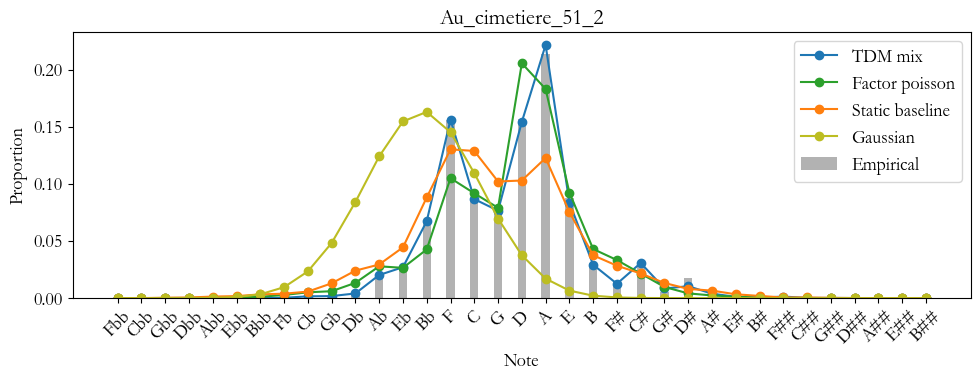

In [ ]:
# One is invited to the change the idx
idx = 1

empirical = data_faure[idx] # true tpc distribution

x = np.arange(len(notes))

# the plot (bars for empirical + lines for predictions)
plt.figure(figsize=(10, 4))
plt.bar(x, empirical, width=0.35, color="gray", alpha=0.6, label="Empirical")
#plt.plot(x, dist_mix[idx], "-o", color="tab:blue", label="TDM mix")
plt.plot(x, binomial_dist[idx], "-o", color="tab:blue", label="TDM (Binomial)")
plt.plot(x, poisson_dist[idx], '-o', label="TDM (Poisson)", color='tab:red')
plt.plot(x, gamma_dist[idx], "-o", label="TDM (gamma)", color='tab:cyan')
plt.plot(x, binomial_tritones_dist[idx], "-o", label="TDM (binomial) tritones", color='tab:purple')
plt.plot(x, factor_poisson_dist[idx], "-o", label="Factor poisson", color='tab:green')
plt.plot(x, static_dist[idx], "-o", color="tab:orange", label="Static baseline")
plt.plot(x, dist_gauss[idx], "-o", label="Gaussian", color='tab:olive')
plt.xticks(x, notes, rotation = 45)
plt.ylabel("Proportion")
plt.xlabel("TPC")
plt.title(f"{titles_faure[idx]}")
plt.legend()
plt.tight_layout()
plt.show()

## 2.5. Saving results and parameters

In [19]:
results_faure = faure.drop(columns=notes)

array([0.00075173, 0.0013064 , 0.00219959, 0.00358179, 0.00563004,
       0.00852468, 0.01240939, 0.01734078, 0.0232426 , 0.02988451,
       0.03690241, 0.04385866, 0.05031613, 0.05589646, 0.06031185,
       0.06337317, 0.06497968, 0.06509917, 0.06375308, 0.06101498,
       0.05701718, 0.05195604, 0.0460922 , 0.03974379, 0.03326461,
       0.02700403, 0.02125952, 0.0162404 , 0.0120526 , 0.00870469,
       0.00613027, 0.00421837, 0.00284191, 0.00187798, 0.00121933])

In [24]:
results_faure["loss_poisson"] = poisson_loss
results_faure["dist_poisson"] = list(poisson_dist)
results_faure["centers_poisson"] = poisson_centers
faure_params["shift_poisson"] = poisson_params["shift"]
faure_params["weights_poisson"] = list(poisson_params["weights"])
results_faure["centers_poisson"] = poisson_centers

In [28]:
results_faure.to_csv(r"C:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\Corpusfaurecomplete_results2.csv", index=False, encoding="utf-8")
faure_params.to_csv(r"C:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\Corpusfaurecomplete_params2.csv", index=False, encoding="utf-8")

In [ ]:
# Columns creation
# loss
results_faure["loss_binomial"] = binomial_loss
results_faure["loss_poisson"] = poisson_loss
results_faure["loss_gamma"] = gamma_loss
results_faure["loss_binomial_tritones"] = binomial_tritones_loss
results_faure["loss_factor_poisson"] = factor_poisson_loss
results_faure["loss_static"] = static_loss
results_faure["loss_gaussian"] = loss_gauss
#results_faure["loss_mix_tritones"] = loss_mix

# predicted pitch-class distribution associated to best parameters
results_faure["dist_binomial"] = list(binomial_dist)
results_faure["dist_poisson"] =list(poisson_dist)
results_faure["dist_gamma"] = list(gamma_dist)
results_faure["dist_binomial_tritones"] = list(binomial_tritones_dist)
results_faure["dist_factor_poisson"] = list(factor_poisson_dist)
results_faure["dist_static"] = list(static_dist)
results_faure["dist_gaussian"] = list(dist_gauss)
#results_faure["dist_mix"] = list(dist_mix)

# best tonal origins
results_faure["centers_binomial"] = binomial_centers
results_faure["centers_poisson"] = poisson_centers
results_faure["centers_gamma"] = gamma_centers
results_faure["centers_binomial_tritones"] = binomial_tritones_centers
results_faure["centers_factor_poisson"] = factor_poisson_centers
results_faure["centers_static"] = static_centers
results_faure["centers_gaussian"] = centers_gauss
#results_faure["centers_weights_mix"] = list(center_weights)
#results_faure["mean_distances_centers"] = mean_distances

In [ ]:
# To obtain the true name of the tonal origin, and not the number by which it is encoded, we use the value for Binomial TDM as it is the most efficient.
tonal_origin = []
for i in range(len(np.array(binomial_centers))):
    k = np.array(binomial_centers)[i] -1 # begins to 1
    tonal_origin.append(notes[k])
   
results_faure["tonal_origin"] = tonal_origin

Saving parameters for each instance of the model

In [20]:
faure_params = faure.drop(columns=notes)

In [ ]:
# shifts
faure_params["shift_binomial"] = binomial_params["shift"]
faure_params["shift_poisson"] = poisson_params["shift"]
faure_params["shift_binomial_tritones"] = binomial_tritones_params["shift"]
faure_params["shift_gamma"] = gamma_params["shift"]
# weights
faure_params["weights_binomial"] = list(binomial_params["weights"])
faure_params["weights_poisson"] = list(poisson_params["weights"])
faure_params["weights_binomial_tritones"] = list(binomial_tritones_params["weights"])
faure_params["weights_gamma"] = list(gamma_params["weights"])
# probs/rate
faure_params["probs_binomial"] = list(binomial_params["probs"])
faure["probs_binomial_tritones"] = list(binomial_tritones_params["probs"])
faure_params["rate_poisson"] = list(poisson_params["rate"])
faure_params["rate_gamma"] = list(gamma_params["rate"])

In [ ]:
results_faure.to_csv(r"C:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\corpusfaurecomplete_results.csv", index=False)
faure_params.to_csv(r"C:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\corpusfaurecomplete_params.csv", index=False)

Oeuvres de Bach Beethoven extraites du tpc_corpus utilisées dans l'article original

# 3. (BONUS) Evaluation de la variante tritons sur le reste du corpus TP3C (Bach, Beethoven)

## 3.1 Données

In [19]:
tpc_corpus = pd.read_csv(r"C:\Users\sacha\OneDrive\Bureau\Mvp_LeviMazloum\tpc_corpus.csv") # on utilise le corpus TP3C fourni par les auteurs du TDM
bach = tpc_corpus[tpc_corpus.composer == "Bach"].reset_index(drop=True)
beethov = tpc_corpus[tpc_corpus.composer == "Beethoven"].reset_index(drop=True)


In [20]:
def data_weights_labels(corpus):
    counts = corpus.iloc[:, 13:-1].values
    labels = corpus.columns[13:-1].values
    # transformation des comptages en fréquences
    weights_all = np.ones(len(corpus))
    data_all = counts / counts.sum(axis=1, keepdims=True)
    return data_all, weights_all, labels

bach_prepared = data_weights_labels(bach)
beethov_prepared = data_weights_labels(beethov)


In [24]:
len(beethov)

108

## 3.2 Lancement des modèles

Binomial avec tritons

In [21]:
bach_binomial_tritones_dist, bach_binomial_tritones_loss, bach_binomial_tritones_centers, bach_binomial_tritones_params = evaluate_tdm(bach_prepared[0], bach_prepared[1], TonalDiffusionModel(path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:06<1:15:17,  6.46s/it]

iteration 0
    loss: 0.22068580767708312


  7%|▋         | 51/700 [06:35<1:20:03,  7.40s/it]

iteration 50
    loss: 0.11779832269357235


 14%|█▍        | 101/700 [13:48<1:30:43,  9.09s/it]

iteration 100
    loss: 0.11174122559291746


 22%|██▏       | 151/700 [21:24<1:22:28,  9.01s/it]

iteration 150
    loss: 0.1099725551829746


 29%|██▊       | 201/700 [31:52<4:17:21, 30.94s/it] 

iteration 200
    loss: 0.10903690734946161


 36%|███▌      | 251/700 [39:21<1:07:55,  9.08s/it]

iteration 250
    loss: 0.10863067970981621


 43%|████▎     | 301/700 [46:46<58:54,  8.86s/it]  

iteration 300
    loss: 0.10824880657485096


 46%|████▋     | 325/700 [49:56<57:37,  9.22s/it]


In [25]:
beethoven_binomial_tritones_dist, beethoven_binomial_tritones_loss, beethoven_binomial_tritones_centers, beethoven_binomial_tritones_params = evaluate_tdm(beethov_prepared[0], beethov_prepared[1], TonalDiffusionModel(path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 1/700 [00:06<1:21:26,  6.99s/it]

iteration 0
    loss: 0.15505015957462176


  7%|▋         | 51/700 [06:08<1:21:24,  7.53s/it]

iteration 50
    loss: 0.07915292351481873


 14%|█▍        | 101/700 [12:05<1:10:52,  7.10s/it]

iteration 100
    loss: 0.07396831385428307


 22%|██▏       | 151/700 [17:56<1:03:51,  6.98s/it]

iteration 150
    loss: 0.07173889188410387


 29%|██▊       | 201/700 [23:26<42:28,  5.11s/it]  

iteration 200
    loss: 0.07146115606151687


 36%|███▌      | 251/700 [29:06<52:32,  7.02s/it]

iteration 250
    loss: 0.07128468255869602


 43%|████▎     | 301/700 [35:00<47:05,  7.08s/it]

iteration 300
    loss: 0.07102048891818949


 50%|█████     | 351/700 [40:54<40:38,  6.99s/it]

iteration 350
    loss: 0.07111533490152111


 52%|█████▏    | 362/700 [42:23<39:34,  7.03s/it]


Binomial classique

In [34]:
bach_binomial_dist, bach_binomial_loss, bach_binomial_centers, bach_binomial_params = evaluate_tdm(bach_prepared[0], bach_prepared[1], TonalDiffusionModel(path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:10<2:03:39, 10.61s/it]

iteration 0
    loss: 0.22068580767708312


  7%|▋         | 51/700 [07:12<1:18:43,  7.28s/it]

iteration 50
    loss: 0.11779832269357235


 14%|█▍        | 101/700 [15:53<1:43:19, 10.35s/it]

iteration 100
    loss: 0.11174122559291746


 22%|██▏       | 151/700 [24:34<1:36:26, 10.54s/it]

iteration 150
    loss: 0.1099725551829746


 29%|██▊       | 201/700 [32:12<49:22,  5.94s/it]  

iteration 200
    loss: 0.10903690734946161


 36%|███▌      | 251/700 [36:56<42:41,  5.71s/it]

iteration 250
    loss: 0.10863067970981621


 43%|████▎     | 301/700 [41:46<38:14,  5.75s/it]

iteration 300
    loss: 0.10824880657485096


 46%|████▋     | 325/700 [44:12<51:00,  8.16s/it]


In [35]:
beethoven_binomial_dist, beethoven_binomial_loss, beethoven_binomial_centers, beethoven_binomial_params = evaluate_tdm(beethov_prepared[0], beethov_prepared[1], TonalDiffusionModel(path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:06<1:18:52,  6.77s/it]

iteration 0
    loss: 0.15505015957462176


  7%|▋         | 51/700 [04:40<1:07:39,  6.26s/it]

iteration 50
    loss: 0.07915292351481873


 14%|█▍        | 101/700 [10:26<1:10:27,  7.06s/it]

iteration 100
    loss: 0.07396831385428307


 22%|██▏       | 151/700 [16:19<1:06:26,  7.26s/it]

iteration 150
    loss: 0.07173889188410387


 29%|██▊       | 201/700 [22:09<57:00,  6.85s/it]  

iteration 200
    loss: 0.07146115606151687


 36%|███▌      | 251/700 [27:52<51:44,  6.91s/it]

iteration 250
    loss: 0.07128468255869602


 43%|████▎     | 301/700 [33:54<50:24,  7.58s/it]

iteration 300
    loss: 0.07102048891818949


 50%|█████     | 351/700 [39:52<41:53,  7.20s/it]

iteration 350
    loss: 0.07111533490152111


 52%|█████▏    | 362/700 [41:16<38:32,  6.84s/it]


Binomial 1d (censé être plus adapté à Bach)

In [36]:
bach_binomial1d_dist, bach_binomial1d_loss, bach_binomial1d_centers, bach_binomial1d_params = evaluate_tdm(bach_prepared[0], bach_prepared[1], TonalDiffusionModel(interval_steps = (1, -1, -3, 3, 4, -4, 6, -6), path_dist=Binomial, soft_max_posterior=False, margin =0.5), dict(defaults=dict(lr=5e-2)))

  0%|          | 1/700 [00:09<1:49:47,  9.42s/it]

iteration 0
    loss: 0.9273561533743218


  7%|▋         | 51/700 [06:41<1:12:51,  6.74s/it]

iteration 50
    loss: 0.1351526577946


 14%|█▍        | 101/700 [12:30<1:23:57,  8.41s/it]

iteration 100
    loss: 0.11142683828145974


 22%|██▏       | 151/700 [19:35<1:21:39,  8.92s/it]

iteration 150
    loss: 0.10604787866274804


 29%|██▊       | 201/700 [26:29<52:21,  6.29s/it]  

iteration 200
    loss: 0.10353454099728453


 36%|███▌      | 251/700 [31:57<44:22,  5.93s/it]  

iteration 250
    loss: 0.1020031304073662


 43%|████▎     | 301/700 [38:15<57:38,  8.67s/it]

iteration 300
    loss: 0.10102233088166676


 50%|█████     | 351/700 [45:28<50:35,  8.70s/it]

iteration 350
    loss: 0.10047457195511918


 57%|█████▋    | 401/700 [52:54<46:22,  9.31s/it]

iteration 400
    loss: 0.10048819545922691


 57%|█████▋    | 401/700 [53:03<39:33,  7.94s/it]


KeyboardInterrupt: 

## 3.3 Visualisation

In [ ]:
# On pourra changer au besoin l'indice et le compositeur 
idx =48

empirical = bach_prepared[0][idx] # la vraie distribution des tpc

x = np.arange(len(bach_prepared[2]))

# le plot (barres pour empirical + lignes pour les prédictions)
plt.figure(figsize=(10, 4))
plt.bar(x, empirical, width=0.35, color="gray", alpha=0.6, label="Empirical")
plt.plot(x, bach_binomial_tritones_dist[idx], "-o", color="tab:blue", label="TDM (Binomial) tritones")
plt.plot(x, bach_binomial_dist[idx], "-o", color="tab:red", label="TDM (Binomial)")
plt.plot(x, bach_binomial1d_dist[idx], "-o", color="tab:blue", label="TDM (Binomial, 1d)")
plt.xticks(x, notes)
plt.ylabel("Probabilité")
plt.xlabel("tpc")
plt.title(f"{bach["work catalogue"][idx]} {bach["opus"][idx]} n°{bach["no"][idx]}")
plt.legend()
plt.tight_layout()
plt.show()

## 3.4 Tests "ad-hoc"

In [ ]:
fig = plt.figure(figsize=(14, 8))
plt.suptitle("Figure")

# beethoven
plt.subplot(1, 2, 1)
plt.boxplot([beethoven_binomial_tritones_loss, beethoven_binomial_loss])
plt.suptitle("Beethoven")
plt.xlabel("Modèle")
plt.ylabel("KL divergence")
plt.xticks([1, 2], ["Binomial tritones", "Binomial"])
plt.show()

# bach
plt.subplot(1, 2, 2)
plt.boxplot([bach_binomial_tritones_loss, bach_binomial_loss, bach_binomial1d_loss])
plt.suptitle("Bach")
plt.xlabel("Modèle")
plt.ylabel("KL divergence")
plt.xticks([1, 2, 3], ["Binomial tritones", "Binomial", "Binomial 1d"])
plt.show()

In [ ]:
for i in [beethoven_binomial_tritones_loss, beethoven_binomial_loss] :
    print(f"Loss moyenne pour le modèle {i[8:-5]} : {i.mean()}")
for j in [bach_binomial_tritones_loss, bach_binomial_loss, bach_binomial1d_loss]:
    print(f"Loss moyenne pour le modèle {i[4:-5]} : {j.mean()}")


In [ ]:
stat, p = mannwhitneyu(
        beethoven_binomial_tritones_loss, beethoven_binomial_loss,
        alternative="two-sided"
    )
print(f"Performances Binomial tritons Binomial classique pour Beethoven : U = {stat:.3f}, p = {p:.4f}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3211009152.py, line 2)

In [ ]:
stat, p = mannwhitneyu(
        bach_binomial_tritones_loss, bach_binomial1d_loss,
        alternative="two-sided"
    )
print(f"Performances Binomial tritons Binomial classique 1D pour Bach : U = {stat:.3f}, p = {p:.4f}")